- Image classification is the process of assigning an image to one of several predefined categories.  
- The CIFAR-10 dataset consists of 60,000 color images, each of size 32x32 pixels.  
- These images are grouped into ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.  
- Out of the total images, 50,000 are used for training and 10,000 are used for testing.  
- The model is built using the Keras API from TensorFlow for simplicity and flexibility.  
- Training image data can be computationally demanding, so using GPU support is beneficial.  
- If GPU is not available locally, training can be done in cloud environments such as Kaggle Notebooks or Google Colab.


- Before building the model, the necessary Python libraries must be imported.  
- This includes TensorFlow (for model development), NumPy (for numerical operations), and other helper modules as needed.  
- If a library is not already installed, it can be added using:
  - pip install tensorflow   (from command prompt or terminal)
  - or, inside a Kaggle / Jupyter notebook:  !pip install tensorflow  
- Once installed, the library can be imported and used directly in the code.  
- The same approach applies to any additional modules required in the project.


In [1]:
# Import TensorFlow library
import tensorflow as tf   

# Print the current TensorFlow version
print(tf.__version__)     

# Import NumPy for numerical operations
import numpy as np

# Import Matplotlib for plotting images and graphs
import matplotlib.pyplot as plt

# Import layers needed to build the CNN model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

# Import Model class for creating a functional model
from tensorflow.keras.models import Model


2025-10-26 12:51:32.945314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761483093.197120      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761483093.262091      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [2]:
# Import TensorFlow
import tensorflow as tf

# Override TensorFlow's dataset download function so that it reads the dataset
# directly from the local Kaggle input folder instead of trying to download it.
tf.keras.utils.get_file = lambda *args, **kwargs: "/kaggle/input/cifar-10-image/cifar-10-batches-py"



In [3]:
# Import required modules
import os, pickle, numpy as np

# Set the path to the local CIFAR-10 dataset folder
ROOT = "/kaggle/input/cifar-10-image/cifar-10-batches-py"   # Update only if your folder name is different

# Function to load a CIFAR-10 batch file
def _unpickle(fp):
    with open(fp, "rb") as f:
        return pickle.load(f, encoding="bytes")

# Function to load all CIFAR-10 training and test files from the local folder
def _load_cifar10_from_dir(root):
    xs, ys = [], []   # Lists to store training data and labels

    # Load the 5 training batches
    for i in range(1, 6):
        batch = _unpickle(os.path.join(root, f"data_batch_{i}"))
        xs.append(batch[b"data"])
        ys += batch[b"labels"]

    # Convert lists to NumPy arrays
    x_train = np.concatenate(xs, axis=0)
    y_train = np.array(ys)

    # Check and load the test batch (handles names like 'test_batc')
    test_file = "test_batch"
    if not os.path.exists(os.path.join(root, test_file)):
        candidates = [f for f in os.listdir(root) if f.startswith("test_bat")]
        if not candidates:
            raise FileNotFoundError("Could not find test_batch file in the folder.")
        test_file = candidates[0]

    test = _unpickle(os.path.join(root, test_file))
    x_test = test[b"data"]
    y_test = np.array(test[b"labels"])

    # Reshape from (N, 3072) → (N, 32, 32, 3) and fix channel order
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test  = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

# Load dataset locally (no internet download required)
(x_train, y_train), (x_test, y_test) = _load_cifar10_from_dir(ROOT)

# Print the shapes of the loaded data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


- The dataset contains images that are 32×32 pixels in size with 3 color channels, meaning the data consists of colored images.  
- Each image has one corresponding label that indicates which class it belongs to.  
- Even though we have the images and their labels, the data cannot be sent to the neural network in its raw form.  
- The pixel values in the images currently range from 0 to 255. To make training more stable and efficient, these values are scaled to a range between 0 and 1.  
- This scaling is done by dividing all pixel values by 255.0.  
- The labels also need to be formatted properly before being used by the model.  
- If required, label values are flattened or converted into a suitable format (for example, converting them into one-hot encoded vectors).  


In [4]:
# Scale pixel values to the range 0-1 for faster and more stable training
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert label arrays from shape (N,1) to (N,) for easier processing
y_train, y_test = y_train.flatten(), y_test.flatten()

- Before moving further, it is useful to look at a few images from the dataset.  
- Since each image is only 32×32 pixels, the visual quality may appear slightly blurred or low-resolution.  
- We can display a small set of images using a grid layout.  
- This can be done by looping through the first few images and plotting them using the subplot() function from matplotlib.  
- For example, we can show the first 25 images from the training set arranged in a 5×5 grid.


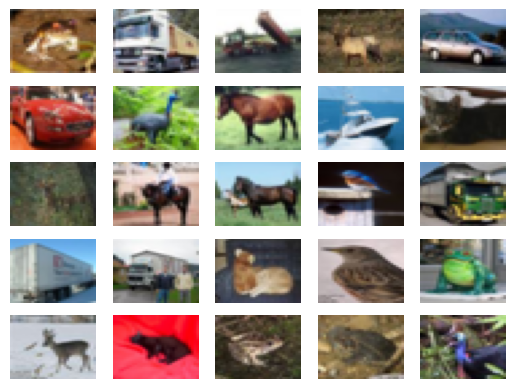

In [5]:
# Create a 5x5 grid of subplots for displaying sample images
fig, ax = plt.subplots(5, 5)
k = 0  # index to track images in x_train

# Loop through the grid and display one image in each cell
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')  # show image
        ax[i][j].axis('off')  # hide axis for cleaner view
        k += 1

# Display the grid of images
plt.show()

- Although the images appear low-resolution, they still contain enough visual information for distinguishing between the different object categories.  
- After preprocessing, we now move on to building the classification model.  
- A Convolutional Neural Network (CNN) is used for this task, as CNNs are well-suited for learning patterns in images.  
- The model will include:
  - Convolutional layers (Conv2D) to extract spatial features from the images  
  - Pooling layers to reduce spatial dimensions and computation  
  - Normalization where needed to stabilize learning  
  - Dense (fully connected) layers to combine the learned features  
  - A final Dense layer that outputs one of the ten classes  
- The ReLU activation function is used in the hidden layers to introduce non-linearity.  
- The output layer uses the Softmax activation function, which converts the final outputs into probability values across the ten classes.


In [6]:

# Find the number of unique classes in the dataset
K = len(set(y_train))

# Print the number of output classes
print("number of classes:", K)

# ----------------------------------------------------
# Build the CNN model using the Functional API
# ----------------------------------------------------

# Input layer specifying the shape of each image
i = Input(shape=x_train[0].shape)

# First convolution block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)   # Conv layer with 32 filters
x = BatchNormalization()(x)                                    # Normalize activations
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)   # Second conv layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)                                    # Downsample by 2x

# Second convolution block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Third convolution block
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output into a vector
x = Flatten()(x)

# Add dropout to reduce overfitting
x = Dropout(0.2)(x)

# Fully connected dense layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer with softmax (one neuron per class)
x = Dense(K, activation='softmax')(x)

# Define the model with input and output layers
model = Model(i, x)

# Display model architecture summary
model.summary()


number of classes: 10


2025-10-26 12:56:43.770737: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,397,226 (9.14 MB)

 Trainable params: 2,396,330 (9.14 MB)

 Non-trainable params: 896 (3.50 KB)

- Once the model architecture is defined, the next step is to compile it before training.  
- The compile() function in Keras allows us to specify how the model will learn.  
- In this project:
  - The **Adam** optimizer is used to adjust the weights during training.
  - The **sparse_categorical_crossentropy** loss function is used because the labels are integer-encoded (not one-hot).
  - The model will track **accuracy** as the performance metric.


In [8]:
# Compile the model before training
# Adam optimizer adjusts weights efficiently during training
# sparse_categorical_crossentropy is used because labels are integer encoded
# We track accuracy as the performance metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


- After compiling the model, we train it using the fit() function.  
- The training data is passed to the model along with the number of epochs to run.  
- In this case, the model is trained for 50 epochs, which is generally enough to observe stable learning.  
- The number of epochs can be adjusted depending on how the model performs (increasing may improve accuracy but can also lead to overfitting).


In [13]:
# Train the model on the training data
# validation_data checks performance on the test set during training
# epochs specifies how many times the model will see the entire dataset
r = model.fit(
  x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 234s 150ms/step - accuracy: 0.8362 - loss: 0.4759 - val_accuracy: 0.7773 - val_loss: 0.7208
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 234s 150ms/step - accuracy: 0.8700 - loss: 0.3778 - val_accuracy: 0.7345 - val_loss: 0.8584
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 236s 151ms/step - accuracy: 0.8869 - loss: 0.3247 - val_accuracy: 0.8158 - val_loss: 0.5824
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 235s 150ms/step - accuracy: 0.9062 - loss: 0.2661 - val_accuracy: 0.7971 - val_loss: 0.7027
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 236s 151ms/step - accuracy: 0.9180 - loss: 0.2375 - val_accuracy: 0.8137 - val_loss: 0.6525


- Once the model is trained, it already performs reasonably well.  
- However, to further improve accuracy and reduce overfitting, data augmentation can be applied.  
- Data augmentation artificially increases the variety of training images by applying transformations.  
- In this case, we use:
  - Horizontal flipping
  - Small shifts in image width and height (range of 0.1)
  - Batch size of 32 for training
- After creating the augmented image generator, model.fit() is called again.
- The additional training continues from the previously learned weights and helps the model generalize better.


In [14]:
# Fit with data augmentation
# Note: if you run this AFTER calling
# the previous model.fit()
# it will CONTINUE training where it left off
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

r = model.fit(train_generator, validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 260s 166ms/step - accuracy: 0.7811 - loss: 0.6738 - val_accuracy: 0.7963 - val_loss: 0.6114
Epoch 2/5
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:41 142ms/step - accuracy: 0.6562 - loss: 0.9713

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6562 - loss: 0.9713 - val_accuracy: 0.8008 - val_loss: 0.6024
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 246s 157ms/step - accuracy: 0.8108 - loss: 0.5639 - val_accuracy: 0.8171 - val_loss: 0.5511
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9062 - loss: 0.2821 - val_accuracy: 0.8170 - val_loss: 0.5486
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 245s 157ms/step - accuracy: 0.8292 - loss: 0.5038 - val_accuracy: 0.8282 - val_loss: 0.5103


- After training is complete, it is helpful to observe how the model performed during each epoch.  
- By plotting the accuracy values for both training and validation sets, we can understand how the model’s learning progressed over time.  
- This visualization helps in identifying trends such as improving accuracy, stagnation, or possible overfitting.  
- Other evaluation techniques, such as using a confusion matrix, can also be used for deeper performance analysis.


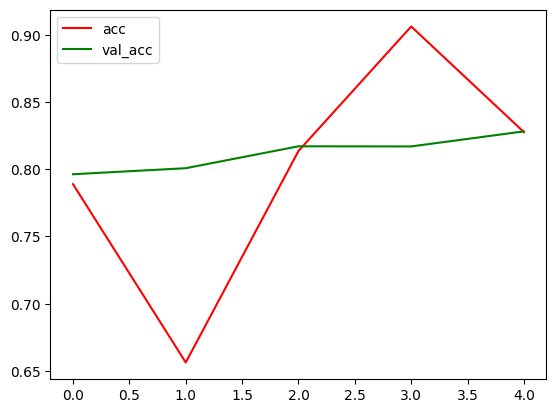

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

- To test the model, we can try predicting the class of a single image.  
- Before passing the image to the model, it must be in the correct format.  
- The pixel values should be scaled between 0 and 1, and the image must be reshaped to (1, 32, 32, 3) since the model expects a batch as input.  
- For convenience, we can choose an image directly from the test dataset because it is already normalized.  
- The reshape() function is used to convert the image into the required shape.  
- After that, model.predict() returns the probability scores for each class, and the highest score indicates the predicted label.  
- Since the image comes from the dataset, we can directly compare the predicted label with the true label.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Original label is cat and predicted label is cat


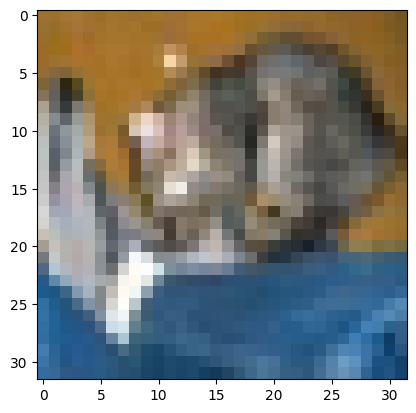

In [16]:
# label mapping

labels = '''airplane automobile bird cat deerdog frog horseship truck'''.split()

# select the image from our test dataset
image_number = 0

# display the image
plt.imshow(x_test[image_number])

# load the image in an array
n = np.array(x_test[image_number])

# reshape it
p = n.reshape(1, 32, 32, 3)

# pass in the network for prediction and 
# save the predicted label
predicted_label = labels[model.predict(p).argmax()]

# load the original label
original_label = labels[y_test[image_number]]

# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

- In the previous example, the model correctly predicted the label (e.g., both the actual and predicted label were "cat").  
- To understand the model’s behavior better, it is also useful to look at cases where the prediction is incorrect.  
- For instance, if we select an image such as the one at index 5722, the model may predict a different class than the true label.  
- Observing such misclassified examples helps us analyze where the model is struggling and which classes are harder to distinguish.  


- After training and evaluating the model, we can save it for future use.  
- Saving the model allows us to load it later without needing to train it again.  
- The model.save() function is used to store the entire model architecture, weights, and optimizer state.  
- We save the model in the `.h5` format, which is commonly used for Keras models.  
- This saved file can later be loaded using the load_model() function when needed.


In [24]:
# save the model
model.save('cifar10_cnn_model.h5')

In [25]:
from tensorflow.keras.models import load_model

model = load_model('cifar10_cnn_model.h5')

# Now you can use it:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,397,228 (9.14 MB)

 Trainable params: 2,396,330 (9.14 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)